# Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

###df_ratings = pd.read_csv('./data/ml-latest-small/ratings.csv')
df = pd.read_csv('./data/ml-latest-small/ratings.csv')
df_movies  = pd.read_csv('./data/ml-latest-small/movies.csv')
###df = pd.merge(df_ratings, df_movies, on='movieId')

# EDA

In [2]:
# Display the first few rows of the dataset
print(df.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [3]:
# Descriptive statistics for numerical features
print(df.describe())

              userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


In [4]:
# Check for missing values in the dataset
print(df.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [5]:
# Replacing infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Ignore FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

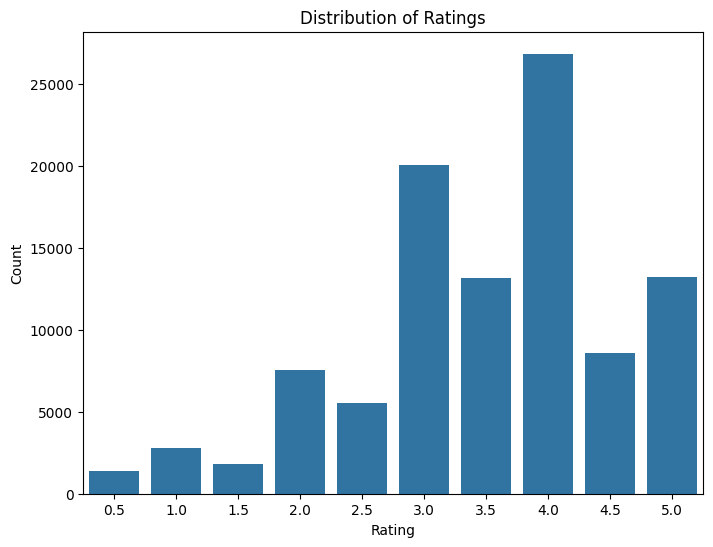

In [6]:
# Distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

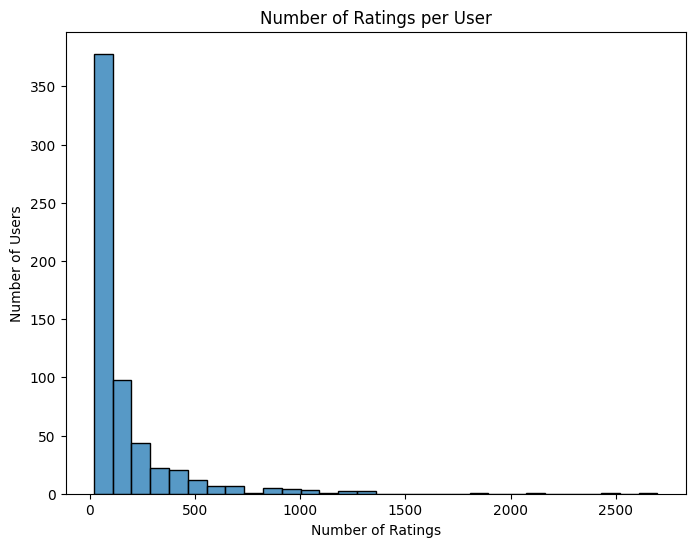

In [7]:
# Number of ratings per user
ratings_per_user = df.groupby('userId')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(ratings_per_user, bins=30, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

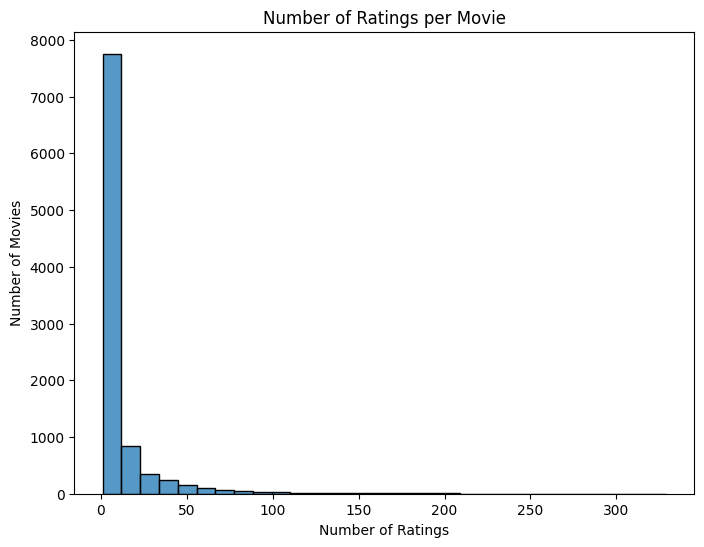

In [8]:
# Number of ratings per movie
ratings_per_movie = df.groupby('movieId')['rating'].count()
plt.figure(figsize=(8, 6))
sns.histplot(ratings_per_movie, bins=30, kde=False)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.show()

In [9]:
# Convert Unix timestamps to readable dates
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

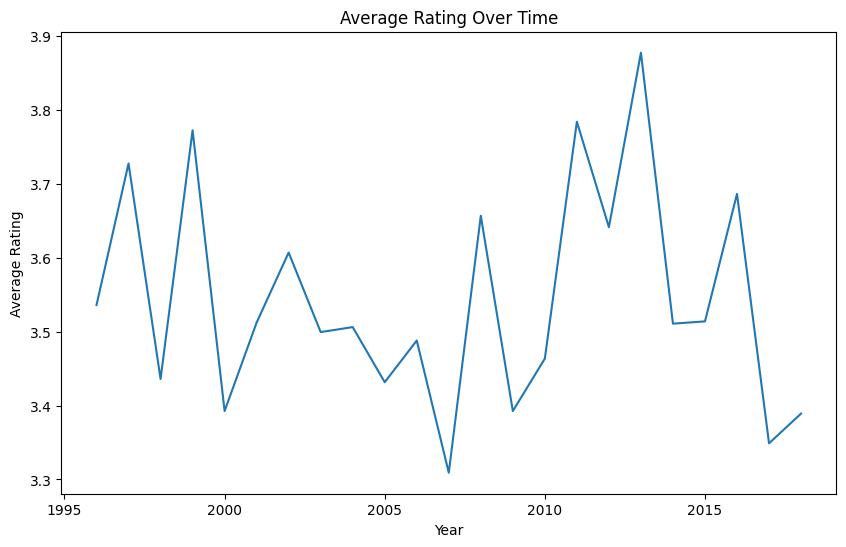

In [10]:
# Ratings over time
plt.figure(figsize=(10, 6))
df.groupby(df['date'].dt.year)['rating'].mean().plot(kind='line')
plt.title('Average Rating Over Time')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


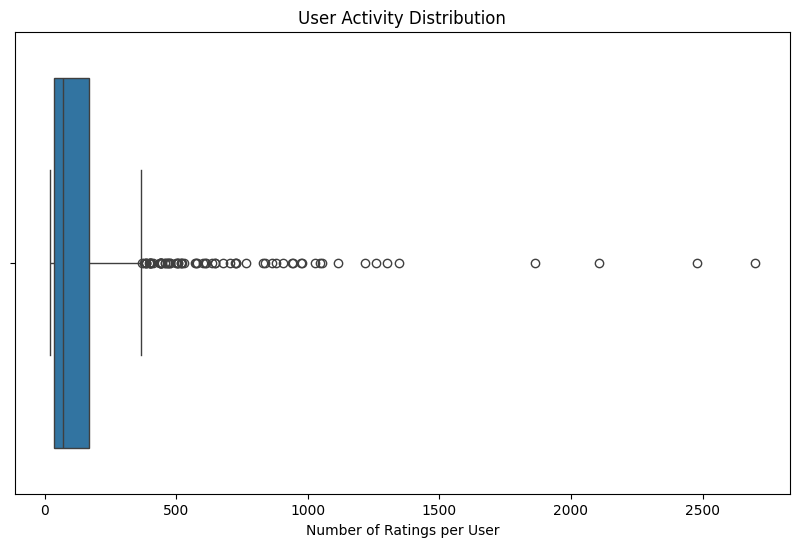

In [11]:
# User activity analysis
user_activity = df.groupby('userId')['rating'].count()
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_activity)
plt.title('User Activity Distribution')
plt.xlabel('Number of Ratings per User')
plt.show()

# Training

In [12]:
from surprise import Dataset, Reader, accuracy, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate, train_test_split
import pickle

def validate_model(df, model_type='SVD'):
    """Validate the model and return it."""
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.30)

    if model_type == 'SVD':
        algo = SVD()
    elif model_type == 'NMF':
        algo = NMF()
    elif model_type == 'KNNBasic':
        algo = KNNBasic()
    elif model_type == 'SlopeOne':
        algo = SlopeOne()
    elif model_type == 'CoClustering':
        algo = CoClustering()
    
    algo.fit(trainset)
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=True)

    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    return algo, rmse, results

def save_model(model, filename):
    """Save the trained model to a file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

def load_model(filename):
    """Load a trained model from a file."""
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

def generate_recommendations(user_id, algo, df):
    """Generate and print movie recommendations for a user."""

    movieRatings = df.groupby('movieId').mean()
    userRatings  = df.groupby('userId').mean()

    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()
    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)

    select_n = 10
    user_predictions = [pred for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x.est, reverse=True)
    top_5_recommendations = user_predictions[:select_n]

    middle_index = len(user_predictions) // 2
    start_index  = max(0, middle_index-select_n)
    end_index    = start_index + select_n
    mid_10_recommendations = user_predictions[start_index:end_index]

    mean_user_rating  = float(userRatings.loc[user_id]['rating'])
    print(f"Top {select_n} recommendations for User {user_id} mean user rating: {mean_user_rating:.2f}")
    for pred in top_5_recommendations:
        mean_movie_rating = float(movieRatings.loc[pred.iid]['rating'])
        print(f"UserID: {user_id}, Movie ID: {pred.iid},\tEst. Rating: {pred.est:.2f},\tMovie Avg Rating: {mean_movie_rating:.2f}")
    
    print(f"\nMiddle {select_n} recommendations")
    for pred in mid_10_recommendations:
        mean_movie_rating = float(movieRatings.loc[pred.iid]['rating'])
##        movie_name = df[ df['movieId'] == pred.iid, 'title'].iloc[0]
##        print(f'movieId: {pred.iid}, {movie_name}')
        print(f"UserID: {user_id}, Movie ID: {pred.iid},\tEst. Rating: {pred.est:.2f},\tMovie Avg Rating: {mean_movie_rating:.2f}")
    
    return top_5_recommendations, mid_10_recommendations

# Predictions

In [13]:
if __name__ == "__main__":
    # Train, validate, and save SVD model
    print("Evaluating and saving SVD Model:")
    svd_model, svd_rmse, svd_results = validate_model(df, 'SVD')
    save_model(svd_model, 'svd_model.pkl')

    # Train, validate, and save NMF model
    print()
    print("Evaluating and saving NMF Model:")
    nmf_model, nmf_rmse, nmf_results  = validate_model(df, 'NMF')
    save_model(nmf_model, 'nmf_model.pkl')

    # Train, validate, and save KNNBasic model
    print()
    print("Evaluating and saving KNNBasic Model:")
    knnbasic_model, knnbasic_rmse, knnbasic_results  = validate_model(df, 'KNNBasic')
    save_model(knnbasic_model, 'knnbasic_model.pkl')

    # Train, validate, and save SlopeOne model
    print()
    print("Evaluating and saving SlopeOne Model:")
    slopeone_model, slopeone_rmse, slopeone_results  = validate_model(df, 'SlopeOne')
    save_model(slopeone_model, 'slopeone_model.pkl')

    # Train, validate, and save CoClustering model
    print()
    print("Evaluating and saving CoClustering Model:")
    coclustering_model, coclustering_rmse, coclustering_results  = validate_model(df, 'CoClustering')
    save_model(coclustering_model, 'coclustering_model.pkl')

    # Load models and generate recommendations
    svd_model          = load_model('svd_model.pkl')
    nmf_model          = load_model('nmf_model.pkl')
    knnbasic_model     = load_model('knnbasic_model.pkl')
    slopeone_model     = load_model('slopeone_model.pkl')
    coclustering_model = load_model('coclustering_model.pkl')

    user_id = 1
    print()
    print("SVD")
    svd_top, svd_mid = generate_recommendations(user_id, svd_model, df)

    print()
    print("NMF")
    nmf_top, nmf_mid = generate_recommendations(user_id, nmf_model, df)

    print()
    print("KNNBasic")
    knnbasic_top, knnbasic_mid = generate_recommendations(user_id, knnbasic_model, df)

    print()
    print("SlopeOne")
    slopeone_top, slopeone_mid = generate_recommendations(user_id, slopeone_model, df)

    print()
    print("CoClustering")
    coclustering_top, coclustering_mid = generate_recommendations(user_id, coclustering_model, df)


Evaluating and saving SVD Model:
RMSE: 0.8785
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8658  0.8778  0.8778  0.8825  0.8666  0.8741  0.0067  
MAE (testset)     0.6648  0.6750  0.6741  0.6752  0.6669  0.6712  0.0044  
Fit time          0.64    0.65    0.65    0.65    0.63    0.64    0.01    
Test time         0.15    0.06    0.15    0.06    0.07    0.10    0.04    
Model saved to svd_model.pkl

Evaluating and saving NMF Model:
RMSE: 0.9408
Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9275  0.9148  0.9203  0.9154  0.9161  0.9188  0.0047  
MAE (testset)     0.7086  0.7040  0.7047  0.7014  0.6987  0.7035  0.0033  
Fit time          1.35    1.25    1.28    1.24    1.28    1.28    0.04    
Test time         0.18    0.05    0.04    0.04    0.04    0.07    0.06    
Model saved to nmf_m

In [19]:
from collections import defaultdict

movie_recommendations = {}
recommend = { 'top' : svd_top, 'middle' : svd_mid, 'rmse' : svd_rmse, 'results' : svd_results }
movie_recommendations['SVD'] = recommend

recommend = { 'top' : nmf_top, 'middle' : nmf_mid, 'rmse' : nmf_rmse, 'results' : nmf_results }
movie_recommendations['NMF'] = recommend

recommend = { 'top' : knnbasic_top, 'middle' : knnbasic_mid, 'rmse' : knnbasic_rmse, 'results' : knnbasic_results }
movie_recommendations['KNNBasic'] = recommend

recommend = { 'top' : slopeone_top, 'middle' : slopeone_mid, 'rmse' : slopeone_rmse, 'results' : slopeone_results }
movie_recommendations['SlopeOne'] = recommend

recommend = { 'top' : coclustering_top, 'middle' : coclustering_mid, 'rmse' : coclustering_rmse, 'results' : coclustering_results }
movie_recommendations['CoClustering'] = recommend

print(f'RMSE\tMAE\tFit Time\tTest Time')
print(f'====\t===\t========\t=========')
print()
for model_name, rec in movie_recommendations.items():
    print(f'Model: {model_name}')
    print(f'-------------------')
    results = rec['results']
    test_rmse = np.mean( results['test_rmse'])
    test_mae  = np.mean( results['test_mae'] )
    fit_time  = np.mean( results['fit_time'])
    test_time = np.mean( results['test_time'])
    print(f'{test_rmse:.2f}\t{test_mae:.2f}\t{fit_time:.5f}\t{test_time:.5f}')
 
    top = rec['top']
    mid = rec['middle']
    print(f"Top Movie Recommendations")
    for elem in top:
        movieID = elem[1]
        movieName = df_movies[ df_movies['movieId']==movieID]['title'].iloc[0]
        print(f'{movieName}')
    print(f'Middle Range Movie Recommendations')
    for elem in mid:
        movieID = elem[1]
        movieName = df_movies[ df_movies['movieId']==movieID]['title'].iloc[0]
        print(f'{movieName}')

    print()    



RMSE	MAE	Fit Time	Test Time
====	===	========	=========

Model: SVD
-------------------
0.87	0.67	0.64479	0.09755
Top Movie Recommendations
Shawshank Redemption, The (1994)
In the Name of the Father (1993)
Rear Window (1954)
North by Northwest (1959)
Seven Samurai (Shichinin no samurai) (1954)
Terminator 2: Judgment Day (1991)
Trainspotting (1996)
Kiss Kiss Bang Bang (2005)
Army of Darkness (1993)
Ghost in the Shell (Kôkaku kidôtai) (1995)
Middle Range Movie Recommendations
Fat Man and Little Boy (1989)
Three Fugitives (1989)
Extreme Days (2001)
Fat Girl (À ma soeur!) (2001)
Running Scared (1980)
World Traveler (2001)
New Waterford Girl (1999)
They Call Me Bruce? (a.k.a. A Fistful of Chopsticks) (1982)
Prozac Nation (2001)
Alex and Emma (2003)

Model: NMF
-------------------
0.92	0.70	1.27835	0.07111
Top Movie Recommendations
Shawshank Redemption, The (1994)
Good Will Hunting (1997)
Dark Knight, The (2008)
Town, The (2010)
Inside Job (2010)
Warrior (2011)
Wolf of Wall Street, The (2013



| Observation    |  SVD     |  NMF    |  KNNBasic |  SlopeOne  |  CoClustering  |
|----------------|----------|---------|-----------|------------|----------------|
| RMSE (testset) |  0.8732  |  0.9235 |  0.9483   |  0.9009    |  0.9451        |
| MAE (testset)  |  0.6711  |  0.7057 |  0.7263   |  0.6882    |  0.7316        |
| Fit time       |  0.73    |  1.35   |  0.11     |  2.05      |  1.87          |
| Test time      |  0.11    |  0.07   |  0.71     |  3.43      |  0.08          |



# Results

In this case, the SVD (Singular Value Decomposition) model generally performs better than the NMF (Non-negative Matrix Factorization) model based on the evaluation metrics provided.